In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import os
import math
import json
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def __save_model(model_name, model, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    torch.save(model.state_dict(), p)
    return p

def save_model(models, root='./model'):
    p = {}
    for k, m in models.items():
        p[k] = __save_model(k, m, root)
    return p

def __load_model(model_name, model, root):
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    if not os.path.isfile(p):
        msg = "No model parameters file for {}!".format(model_name)
        return print(msg)
        raise AttributeError(msg)
    paras = torch.load(p)
    model.load_state_dict(paras)

def load_model(models, root='./model'):
    for k, m in models.items():
        __load_model(k, m, root)
        
def save_model_by_score(models, bleu_score, root):
    p = os.path.join(root, 'score.json')
    previous = None
    
    if np.isnan(bleu_score):
        raise AttributeError("BLEU score become {}".format(bleu_score))
        return
    
    if os.path.isfile(p):
        with open(p, 'r') as f:
            previous = json.load(f)
            
    if previous is not None and previous['score'] > bleu_score:
        return;
    
    save_model(models, root)
    previous = {'score' : bleu_score}
    with open(p, 'w') as f:
        json.dump(previous, f)

In [4]:
class CharDict:
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.n_words = 0
        
        for i in range(26):
            self.addWord(chr(ord('a') + i))
        
        tokens = ["SOS", "EOS"]
        for t in tokens:
            self.addWord(t)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def longtensorFromString(self, s):
        s = ["SOS"] + list(s) + ["EOS"]
        return torch.LongTensor([self.word2index[ch] for ch in s])
    
    def stringFromLongtensor(self, l, show_token=False, check_end=True):
        s = ""
        for i in l:
            ch = self.index2word[i.item()]
            if len(ch) > 1:
                if show_token:
                    __ch = "<{}>".format(ch)
                else:
                    __ch = ""
            else:
                __ch = ch
            s += __ch
            if check_end and ch == "EOS":
                break
        return s

class wordsDataset(Dataset):
    def __init__(self, train=True):
        if train:
            f = './train.txt'
        else:
            f = './test.txt'
        self.datas = np.loadtxt(f, dtype=np.str)
        
        if train:
            self.datas = self.datas.reshape(-1)
        else:
            '''
            sp -> p
            sp -> pg
            sp -> tp
            sp -> tp
            p  -> tp
            sp -> pg
            p  -> sp
            pg -> sp
            pg -> p
            pg -> tp
            '''
            self.targets = np.array([
                [0, 3],
                [0, 2],
                [0, 1],
                [0, 1],
                [3, 1],
                [0, 2],
                [3, 0],
                [2, 0],
                [2, 3],
                [2, 1],
            ])
        
        #self.tenses = ['sp', 'tp', 'pg', 'p']
        self.tenses = [
            'simple-present', 
            'third-person', 
            'present-progressive', 
            'simple-past'
        ]
        self.chardict = CharDict()
        
        self.train = train
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, index):
        if self.train:
            c = index % len(self.tenses)
            return self.chardict.longtensorFromString(self.datas[index]), c
        else:
            i = self.chardict.longtensorFromString(self.datas[index, 0])
            ci = self.targets[index, 0]
            o = self.chardict.longtensorFromString(self.datas[index, 1])
            co = self.targets[index, 1]
            
            return i, ci, o, co

In [5]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, 
        num_condition, condition_size
    ):
        super(EncoderRNN, self).__init__()
        self.word_size = word_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.latent_size = latent_size

        self.condition_embedding = nn.Embedding(num_condition, condition_size)
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, inputs, init_hidden, input_condition):
        c = self.condition(input_condition)
        
        # get (1,1,hidden_size)
        hidden = torch.cat((init_hidden, c), dim=2)
        
        # get (seq, 1, hidden_size)
        x = self.word_embedding(inputs).view(-1, 1, self.hidden_size)
        
        # get (seq, 1, hidden_size), (1, 1, hidden_size)
        outputs, hidden = self.gru(x, hidden)
        
        # get (1, 1, hidden_size)
        m = self.mean(hidden)
        logvar = self.logvar(hidden)
        
        z = self.sample_z() * torch.exp(logvar/2) + m
        
        return z, m, logvar

    def initHidden(self):
        return torch.zeros(
            1, 1, self.hidden_size - self.condition_size, 
            device=device
        )
    
    def condition(self, c):
        c = torch.LongTensor([c]).to(device)
        return self.condition_embedding(c).view(1,1,-1)
    
    def sample_z(self):
        return torch.normal(
            torch.FloatTensor([0]*self.latent_size), 
            torch.FloatTensor([1]*self.latent_size)
        ).to(device)


# Teacher Forcing

In [6]:
torch.max(torch.softmax(torch.randn(1,28), dim=1), 1)[1]

tensor([24])

In [7]:
#Decoder
class DecoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, condition_size
    ):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word_size = word_size

        self.latent_to_hidden = nn.Linear(
            latent_size+condition_size, hidden_size
        )
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, word_size)
    
    def initHidden(self, z, c):
        latent = torch.cat((z, c), dim=2)
        return self.latent_to_hidden(latent)
    
    def forward(self, x, hidden):
        # get (1, 1, hidden_size)
        x = self.word_embedding(x).view(1, 1, self.hidden_size)
        
        # get (1, 1, hidden_size) (1, 1, hidden_size)
        output, hidden = self.gru(x, hidden)
            
        # get (1, word_size)
        output = self.out(output).view(-1, self.word_size)
        
        return output, hidden

In [8]:
# config

train_dataset = wordsDataset()
test_dataset = wordsDataset(False)

word_size = train_dataset.chardict.n_words
num_condition = len(train_dataset.tenses)
hidden_size = 256
latent_size = 32
condition_size = 8

teacher_forcing_ratio = 0.5
empty_input_ratio = 0.1
KLD_weight = 0.0
LR = 0.05

In [9]:
#encoder = EncoderRNN(word_size, hidden_size, latent_size, num_condition, condition_size).to(device)
#decoder = DecoderRNN(word_size, hidden_size, latent_size, condition_size).to(device)
#encoder, decoder

In [10]:
'''load_model(
    {'encoder':encoder, 'decoder':decoder}, 
    os.path.join('.', 'best')
)'''

"load_model(\n    {'encoder':encoder, 'decoder':decoder}, \n    os.path.join('.', 'best')\n)"

In [11]:
def decode_inference(decoder, z, c, maxlen, teacher=False, inputs=None):
    sos_token = train_dataset.chardict.word2index['SOS']
    eos_token = train_dataset.chardict.word2index['EOS']
    z = z.view(1,1,-1)
    i = 0
    
    outputs = []
    x = torch.LongTensor([sos_token]).to(device)
    hidden = decoder.initHidden(z, c)
    
    for i in range(maxlen):
        # get (1, word_size), (1,1,hidden_size)
        x = x.detach()
        output, hidden = decoder(
            x,
            hidden
        )
        outputs.append(output)
        output_onehot = torch.max(torch.softmax(output, dim=1), 1)[1]
        
        # meet EOS
        if output_onehot.item() == eos_token and not teacher:
            break
        
        if teacher:
            x = inputs[i+1:i+2]
        else:
            x = output_onehot
    
    # get (seq, word_size)
    if len(outputs) != 0:
        outputs = torch.cat(outputs, dim=0)
    else:
        outputs = torch.FloatTensor([]).view(0, word_size).to(device)
    
    return outputs


In [12]:
#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    return sentence_bleu(
        [reference], output,
        weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=cc.method1
    )

def evaluation(encoder, decoder, dataset,show=True):
    encoder.eval()
    decoder.eval()
    
    blue_score = []
    
    for idx in range(len(dataset)):
        data = dataset[idx]
        if dataset.train:
            inputs, input_condition = data
            targets = inputs
            target_condition = input_condition
        else:
            inputs, input_condition, targets, target_condition = data
            
        # input no sos and eos
        z, _, _ = encoder(inputs[1:-1].to(device), encoder.initHidden(), input_condition)
            
        # input has sos and eos
        
        outputs = decode_inference(decoder, z, encoder.condition(target_condition), maxlen=len(targets))
            
        # show output by string
        outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
        inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, check_end=True)
        targets_str = train_dataset.chardict.stringFromLongtensor(targets, check_end=True)
        outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, check_end=True)
        
        if show:
            print(inputs_str, '->', targets_str,':',outputs_str)
        
        blue_score.append( compute_bleu(outputs_str, targets_str) )
    
    if show:
        print('BLEU-4 score : {}'.format(sum(blue_score) / len(blue_score)))
    
    return blue_score

In [13]:
def KLD_weight_annealing(epoch):
    slope = 0.001
    #slope = 0.1
    scope = (1.0 / slope)*2
    
    w = (epoch % scope) * slope
    
    if w > 1.0:
        w = 1.0
    
    return w

def Teacher_Forcing_Ratio(epoch):
    # from 1.0 to 0.0
    slope = 0.01
    level = 10
    w = 1.0 - (slope * (epoch//level))
    if w <= 0.0:
        w = 0.0
    
    return w

In [14]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '{:4d}m {:2d}s'.format(int(m), int(s))


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def KL_loss(m, logvar):
    return torch.sum(0.5 * (-logvar + (m**2) + torch.exp(logvar) - 1))

def trainEpochs(
    name, encoder, decoder, epoch_size, learning_rate=1e-2,
    show_size=1000, KLD_weight=0.0, 
    teacher_forcing_ratio = 1.0, eval_size=100,
    metrics=[],start_epoch=0
):  
    start = time.time()
    #plots = []
    show_loss_total = 0
    plot_loss_total = 0
    plot_kl_loss_total = 0
    char_accuracy_total = 0
    char_accuracy_len = 0
    
    kld_w = 0.0
    tfr = 0.0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(start_epoch, epoch_size):
        encoder.train()
        decoder.train()
        
        if callable(teacher_forcing_ratio):
            tfr = teacher_forcing_ratio(epoch)
        else:
            tfr = teacher_forcing_ratio
        
        if callable(KLD_weight):
            kld_w = KLD_weight(epoch)
        else:
            kld_w = KLD_weight
        
        # get data from train dataset
        for idx in range(len(train_dataset)):   
            data = train_dataset[idx]
            inputs, c = data
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            # input no sos and eos
            z, m, logvar = encoder(inputs[1:-1].to(device), encoder.initHidden(), c)
            
            # decide teacher forcing
            use_teacher_forcing = True if random.random() < tfr else False
            
            # input has sos
            outputs = decode_inference(
                decoder, z, encoder.condition(c), maxlen=inputs[1:].size(0), 
                teacher=use_teacher_forcing, inputs=inputs.to(device))
            
            # target no sos
            output_length = outputs.size(0)
            
            loss = criterion(outputs, inputs[1:1+output_length].to(device))
            kld_loss = KL_loss(m, logvar)
            #loss = criterion(outputs, inputs[:-1].to(device))
                
            #print('crossentropy : {} , kld : {}'.format(loss.item(), kld_loss.item()))
                
            (loss + (kld_w * kld_loss)).backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            show_loss_total += loss.item() + ( kld_w*kld_loss.item() )
            plot_loss_total += loss.item()
            plot_kl_loss_total += kld_loss.item()
            
            # show output by string
            # outputs_onehot = torch.max(outputs, 1)[1]
            outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
            inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, show_token=True)
            outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, show_token=True)
            #print(inputs_str,':',outputs_str)
            
            #char_accuracy_total += (outputs_onehot[:-1] == inputs[1:-1].to(device)).sum().item()
            #char_accuracy_len += len(inputs[1:-1])
            
            if np.isnan(loss.item()) or np.isnan(kld_loss.item()):
                raise AttributeError("Became NAN !! loss : {}, kl : {}".format(loss.item(), kld_loss.item()))
            
        score = 0
        for _ in range(eval_size):
            all_score = evaluation(encoder, decoder, test_dataset, show=False)
            score += sum(all_score) / len(all_score)
        score /= eval_size
        
        save_model_by_score(
            {'encoder':encoder, 'decoder':decoder}, 
            score, 
            os.path.join('.', name)
        )
        
        if (epoch + 1)%show_size == 0:
            show_loss_total /= show_size
            print("{} ({} {}%) \ntotal loss : {:.4f}".format(
                timeSince(start, (epoch+1) / epoch_size),
                epoch+1, (epoch+1)*100/epoch_size, show_loss_total
            ))
            print('bleu score : {:.5f}\n'.format(score))
            show_loss_total = 0
        
        metrics.append((
            plot_loss_total, plot_kl_loss_total, score, 
            kld_w, tfr, learning_rate
        ))
        
        plot_loss_total = 0
        plot_kl_loss_total = 0
        char_accuracy_total = 0
        char_accuracy_len = 0
        
    return metrics

In [16]:
metrics = []
encoder = EncoderRNN(word_size, hidden_size, latent_size, num_condition, condition_size).to(device)
decoder = DecoderRNN(word_size, hidden_size, latent_size, condition_size).to(device)
encoder, decoder

(EncoderRNN(
   (condition_embedding): Embedding(4, 8)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (mean): Linear(in_features=256, out_features=32, bias=True)
   (logvar): Linear(in_features=256, out_features=32, bias=True)
 ), DecoderRNN(
   (latent_to_hidden): Linear(in_features=40, out_features=256, bias=True)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=28, bias=True)
 ))

In [18]:
%%time
metrics_backup = trainEpochs(\
    'training_from_init', \
    encoder, decoder, \
    epoch_size=100, show_size=10, learning_rate=10e-4,\
    KLD_weight=KLD_weight_annealing, \
    teacher_forcing_ratio=Teacher_Forcing_Ratio,\
    metrics=metrics, start_epoch=len(metrics)\
)

  14m  5s (-  126m 47s) (10 10.0%) 
total loss : 51080.9276
bleu score : 0.14129

  28m  3s (-  112m 14s) (20 20.0%) 
total loss : 12906.2759
bleu score : 0.43200

  41m 52s (-   97m 41s) (30 30.0%) 
total loss : 7764.5891
bleu score : 0.56860

  55m 36s (-   83m 24s) (40 40.0%) 
total loss : 7468.8323
bleu score : 0.64307

  69m 18s (-   69m 18s) (50 50.0%) 
total loss : 7774.1158
bleu score : 0.78978

  83m  1s (-   55m 20s) (60 60.0%) 
total loss : 8497.2840
bleu score : 0.74212

  96m 48s (-   41m 29s) (70 70.0%) 
total loss : 9091.6974
bleu score : 0.78854

 110m 29s (-   27m 37s) (80 80.0%) 
total loss : 9925.5349
bleu score : 0.67244

 124m  3s (-   13m 47s) (90 90.0%) 
total loss : 10654.6744
bleu score : 0.72534

 137m 30s (-    0m  0s) (100 100.0%) 
total loss : 11560.6934
bleu score : 0.81188

CPU times: user 2h 13min 27s, sys: 3min 19s, total: 2h 16min 47s
Wall time: 2h 17min 30s


In [19]:
torch.save(metrics, os.path.join('.', 'metrics.pkl'))

In [20]:
metrics_df = pd.DataFrame(metrics, columns=[
    "crossentropy", "kl", "score", "klw", "tfr", "lr"
])
metrics_df.head()

,crossentropy,kl,score,klw,tfr,lr
0,85639.995107,7971.625791,0.037495,0.000,1,0.001
1,73256.171199,19490.467909,0.041331,0.001,1,0.001
2,64031.137931,64462.988265,0.040136,0.002,1,0.001
3,57208.758723,100890.315755,0.074891,0.003,1,0.001
4,51704.954804,110762.118193,0.080361,0.004,1,0.001


In [21]:
metrics_df.to_csv(os.path.join('.', 'metrics_v1.csv'), index=False)

In [22]:
def show_curve(df):
    plt.figure(figsize=(10,6))
    plt.title('Training\nLoss/Score/Weight Curve')
    
    plt.plot(df.index, df.kl, label='KLD', linewidth=3)
    plt.plot(df.index, df.crossentropy, label='CrossEntropy', linewidth=3)
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    h1, l1 = plt.gca().get_legend_handles_labels()
    
    ax = plt.gca().twinx()
    ax.plot(metrics_df.index, metrics_df.score, '.', label='BLEU4-score',c="C2")
    ax.plot(metrics_df.index, metrics_df.klw, '--', label='KLD_weight',c="C3")
    ax.plot(metrics_df.index, metrics_df.tfr, '--', label='Teacher ratio',c="C4")
    ax.set_ylabel('score / weight')
    
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2)
    plt.show()

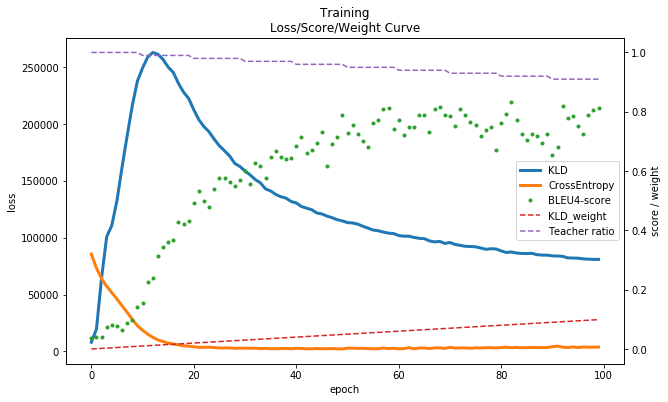

In [23]:
show_curve(metrics_df)

In [29]:
all_score = evaluation(encoder, decoder, test_dataset)

abandon -> abandoned : abannied
abet -> abetting : abetting
begin -> begins : begins
expend -> expends : expires
sent -> sends : sents
split -> splitting : splitting
flared -> flare : flare
functioning -> function : unfocun
functioning -> functioned : functioned
healing -> heals : heals
BLEU-4 score : 0.6928268137077217


In [30]:
def generate_word(encoder, decoder, z, condition, maxlen=20):
    encoder.eval()
    decoder.eval()
    
    outputs = decode_inference(
        decoder, z, encoder.condition(condition), maxlen=maxlen
    )
    
    return torch.max(torch.softmax(outputs, dim=1), 1)[1]

def show_noise(noise):
    plt.title('sample Z')
    plt.plot(list(noise))
    plt.show()

def generate_test(encoder, decoder, noise=None):
    if noise is None:
        noise = encoder.sample_z()
    
    show_noise(noise)
    
    strs = []
    for i in range(len(train_dataset.tenses)):
        outputs = generate_word(encoder, decoder, noise, i)
        output_str = train_dataset.chardict.stringFromLongtensor(outputs)
        print('{:20s} : {}'.format(train_dataset.tenses[i],output_str))
        strs.append(output_str)
    
    return noise, strs

In [31]:
noise = encoder.sample_z()

In [32]:
print(noise)
for i in range(len(train_dataset.tenses)):
    outputs = generate_word(encoder, decoder, noise, i)
    output_str = train_dataset.chardict.stringFromLongtensor(outputs)
    print('{:20s} : {}'.format(train_dataset.tenses[i],output_str))

tensor([ 0.8643, -0.1180, -0.0019,  0.3051,  0.4497,  0.2065, -0.4777,  1.9960,
         1.0836,  0.5932,  0.9396, -0.7346,  1.2446,  0.2731,  0.1963, -0.4946,
        -0.6777,  1.4351, -1.3896,  1.0431,  0.6263,  0.5514, -1.0253,  0.9455,
        -0.4270,  0.8513, -0.0891,  0.0488, -1.8874, -0.1175,  0.9059, -0.5936],
       device='cuda:0')
simple-present       : peculate
third-person         : peculates
present-progressive  : peculating
simple-past          : peculated


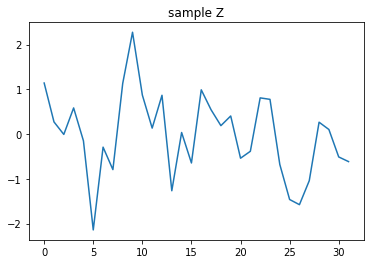

simple-present       : bemon
third-person         : befases
present-progressive  : becks
simple-past          : bemons


(tensor([ 1.1402,  0.2712, -0.0083,  0.5838, -0.1513, -2.1418, -0.2925, -0.7944,
          1.1308,  2.2748,  0.8711,  0.1328,  0.8663, -1.2668,  0.0346, -0.6461,
          0.9884,  0.5424,  0.1878,  0.4039, -0.5399, -0.3850,  0.8083,  0.7754,
         -0.6790, -1.4624, -1.5777, -1.0422,  0.2648,  0.1018, -0.5114, -0.6154],
        device='cuda:0'), ['bemon', 'befases', 'becks', 'bemons'])

In [33]:
generate_test(encoder, decoder)